In [2]:
import sys
sys.path.append("..")
from Package.DQuadratization import *
from Package.EquationSystem import *
from Package.Combinations import *
from qbee import *
import sympy as sp
from Package.Simulation.numerical import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/qbee/util.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Application to reachability analysis - Duffing system

---

Reachability problem is a problem, given an ODE system $\mathbf{x}' = \mathbf{p}(\mathbf{x})$, a set $S\subseteq \mathbb{R}^n$ of possible initial conditions, and a time $t \in \mathbb{R}_{>0}$, compute a set containing the set 
$$
\{\mathbf{x}(t) \mid \mathbf{x}'=\mathbf{p}(\mathbf{x}) \;\&\; \mathbf{x}(0) \in S\} \subseteq \mathbb{R}^n
$$
of all points reachable from $S$ at time $t$.
One recent approach to this problem in the vicinity of a dissipative equilibrium $\mathbf{x}^\ast$ proposed by Forets and Schilling in [Forets_2021] is to use Carleman linearization to reduce the problem to the linear case which is well-studied.
However, the approach described in [Forets_2021] is applicable only to quadratic systems. 
Algorithm 3 allows to lift this restriction by computing a quadratization which preserves the dissipativity of $\mathbf{x}^\ast$.

We will illustrate this idea using the **Duffing** equation
$$
  x'' = kx + ax^{3} + bx'
$$
which described damped oscillator with non-linear restoring force.
The equation can be written as a first-order system by introducing $x_1 := x, x_2 := x'$ as follows
$$
\begin{cases}
    x_1' = x_2,
    x_2' = kx_1 + a x_1^3 + b x_2.
\end{cases}
$$

### Inner-quadratic quadraticization

---

In [9]:
x1, x2 = sp.symbols('x1 x2')
a, k, b = sp.symbols('a k b')

duffing_system = [
    sp.Eq(x1, x2),
    sp.Eq(x2, k * x1 + a * x1 ** 3 + b * x2)
]

duffing_eq_system = EquationSystem(duffing_system)

In [10]:
display(duffing_eq_system.show_system_latex())

<IPython.core.display.Latex object>

In [11]:
inner_quadratic_duffing = optimal_inner_quadratization(duffing_eq_system)

The Original System is: 


<IPython.core.display.Latex object>

The Optimal Dissipative Quadratization is: 


<IPython.core.display.Latex object>

The new introduced variables are: 


<IPython.core.display.Latex object>

The Optimal Quadratic Dissipative System is (with substitution): 


<IPython.core.display.Latex object>

### Dissipative Quadratization

---

We have the Jacobian matrix of the duffing system:
$$
J = \begin{bmatrix}
    0 & 1 \\
    k + 3ax_1^2 & b
\end{bmatrix}
$$
and the equilibrium point $\mathbf{x}^\ast = (0, 0), (-\sqrt{-\frac{k}{a}}, 0), (\sqrt{-\frac{k}{a}}, 0)$. Therefore, we have the value for $x_{1}^{2} = - \frac{k}{a}$ and the Jacobian matrix at the equilibrium point $(-\sqrt{-\frac{k}{a}}, 0), (\sqrt{-\frac{k}{a}}, 0)$ is:
$$
J = \begin{bmatrix}
    0 & 1 \\
    -2k & b
\end{bmatrix}
$$
In physical significance, we have $k,b<0$ and $a$ could be positive or negative. In this case, we have 3 equilibrium points, the origin one is dissipative and the other two are not dissipative. Let's take the value $a=1, b=-1, k=-1$. Then we got equilibrium point $\mathbf{x}^\ast = (0, 0), (-1, 0), (1, 0)$ and dissipative equilibrium point $\mathbf{x}^\ast = (0,0)$.

In [12]:
duffing_system_1 = [
    sp.Eq(x1, x2),
    sp.Eq(x2, - x1 + x1 ** 3 - x2)
]

duffing_eq_system_1 = EquationSystem(duffing_system_1)

#### dissiaptive quadratization with one equilibrium point

In [13]:
# Here we test at equilibrium point (1, 0)
duffing_eq_system_1_one_equilibrium = dquadratization_one_equilibrium(duffing_eq_system_1, {x1: 0, x2: 0}, display=True)

-------------------------- Compute a quadratization dissipative at a given equilibrium --------------------------
The system before coordinate transformation is: 


<IPython.core.display.Latex object>

-------------------------- Dissipative Quadratization on transformed system --------------------------
The Original System is: 


<IPython.core.display.Latex object>

The Optimal Dissipative Quadratization is: 


<IPython.core.display.Latex object>

The new introduced variables are: 


<IPython.core.display.Latex object>

The Optimal Quadratic Dissipative System is (with substitution): 


<IPython.core.display.Latex object>

------------------------------ Optimal Dissipative Quadratization ------------------------------
The eigenvalue with the largest real part is (real part):  -0.5
Mode: Default diagonal value, we will choose the largest eigenvalue as the diagonal value.
The converted Optimal Dissipative Quadratization System is: 


<IPython.core.display.Latex object>

The matrix  associated to the linear part system is:


<IPython.core.display.Latex object>

### Numerical simulation

---

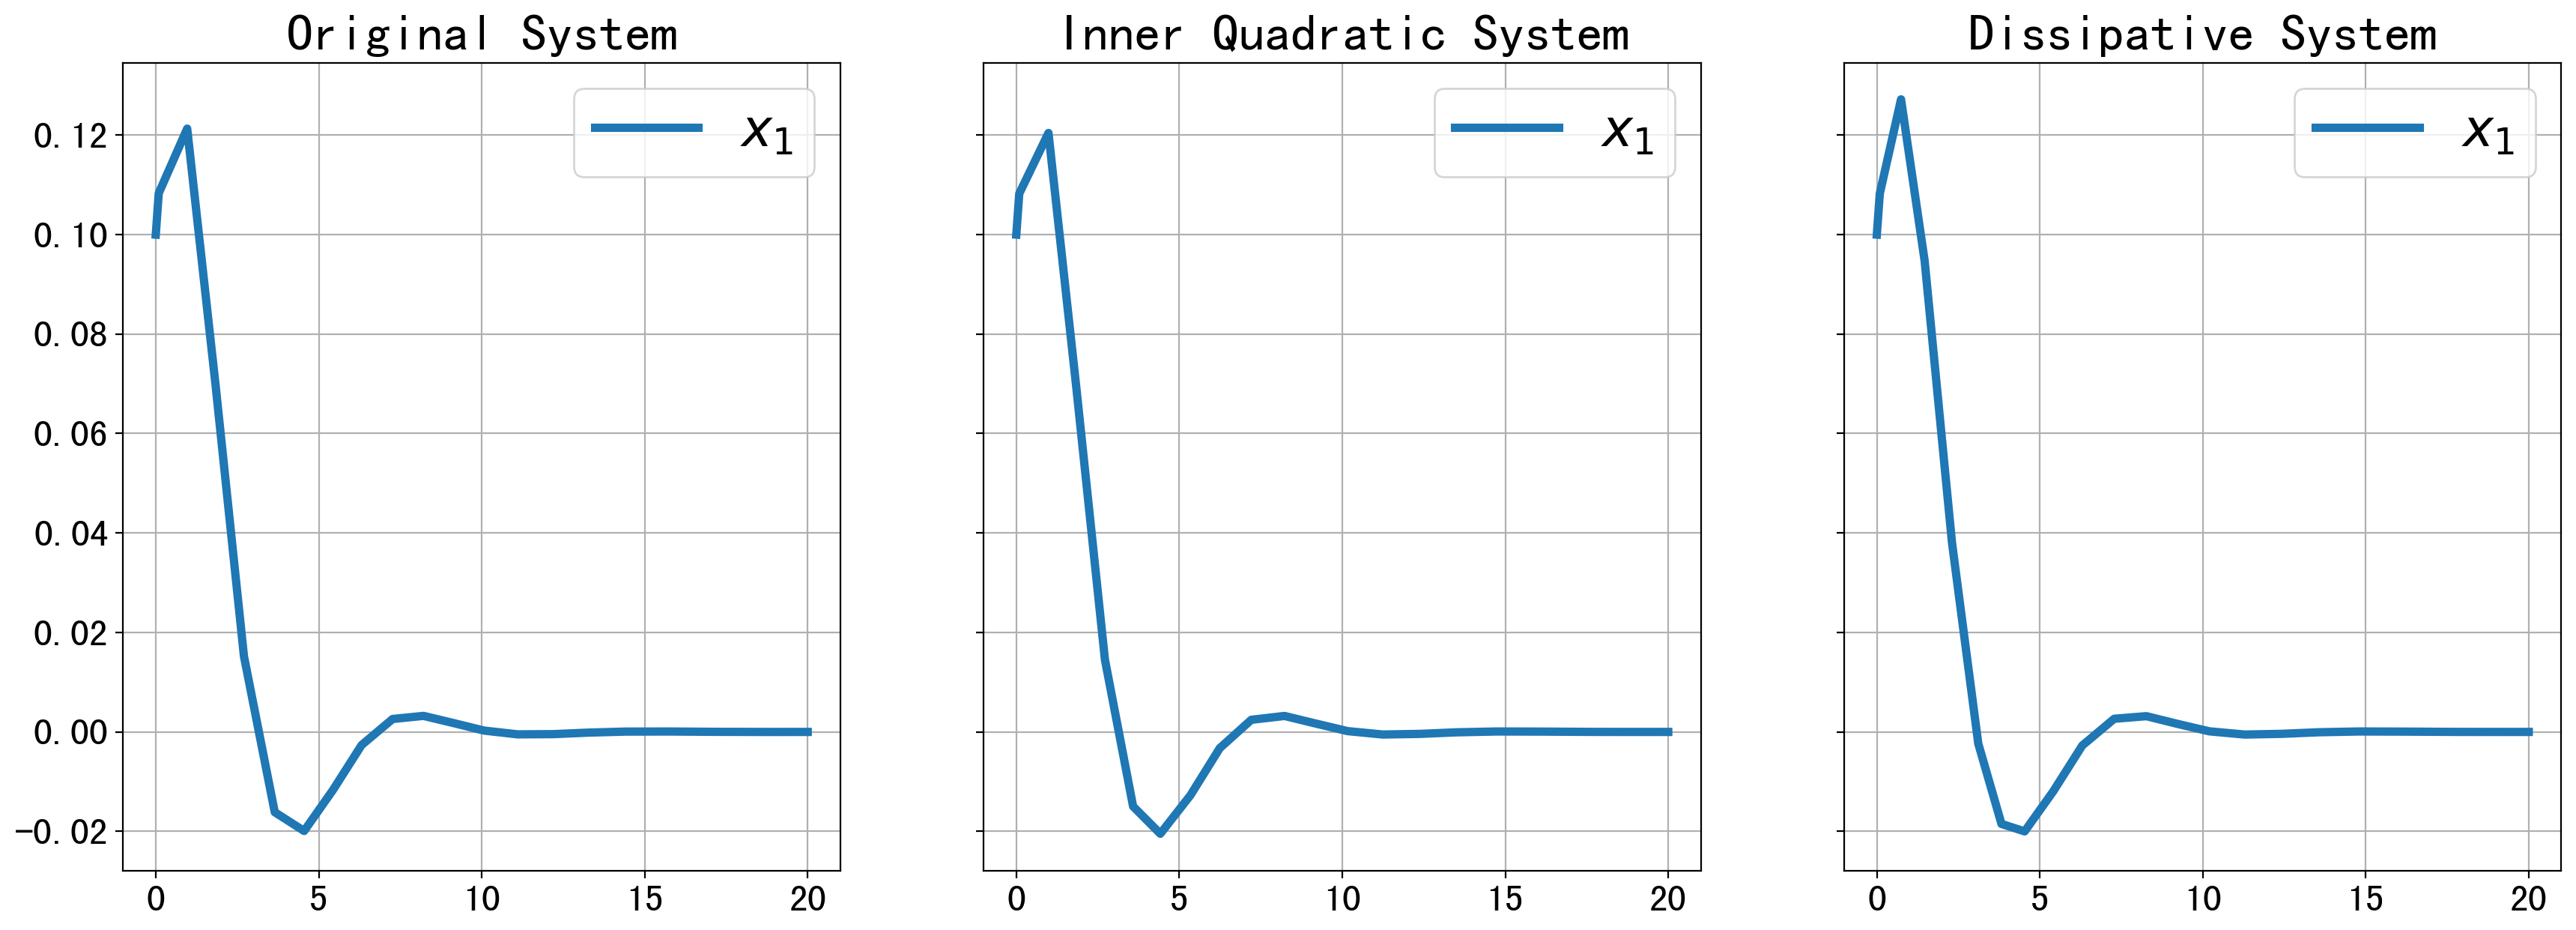

In [18]:
import sympy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

x1, x2, w1, u1 = sp.symbols('x1 x2 w1 u1')
t = sp.symbols('t')

# Define the systems
system_original = [x2, - x1 + x1 ** 3 - x2]
system_innerquadratic = [x2, - x1 + x1 * w1 - x2, 2 * x1 * x2]
system_dissipative = [x2, - x1 - x2 + u1 * x1, - u1 + x1 ** 2 + 2 * x1 * x2]

# Initial conditions
initial_state_original = [0.1, 0.1]
initial_state_innerquadratic = [0.1, 0.1, 0.01]
initial_state_dissipative = [0.1, 0.1, 0.01]

# Convert the systems to functions
fun_original = sp.lambdify((t, [x1, x2]), system_original, "numpy")
fun_innerquadratic = sp.lambdify((t, [x1, x2, w1]), system_innerquadratic, "numpy")
fun_dissipative = sp.lambdify((t, [x1, x2, u1]), system_dissipative, "numpy")

# Time span (from 0 to 10)
t_span = [0, 20]

# Solve the systems
sol_original = solve_ivp(fun_original, t_span, initial_state_original, method='RK45')
sol_innerquadratic = solve_ivp(fun_innerquadratic, t_span, initial_state_innerquadratic, method='RK45')
sol_dissipative = solve_ivp(fun_dissipative, t_span, initial_state_dissipative, method='RK45')

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(21, 7))

ax1.plot(sol_original.t, sol_original.y[0], linewidth=4, label=r"$x_1$")
ax1.legend(fontsize=25)
ax1.set_title('Original System', size=25)
ax1.grid()

ax2.plot(sol_innerquadratic.t, sol_innerquadratic.y[0], linewidth=4, label=r"$x_1$")
ax2.legend(fontsize=25)
ax2.set_title('Inner Quadratic System', size=25)
ax2.grid()

ax3.plot(sol_dissipative.t, sol_dissipative.y[0], linewidth=4, label=r"$x_1$")
ax3.legend(fontsize=25)
ax3.set_title('Dissipative System', size=25)
ax3.grid()

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax3.tick_params(axis='both', which='major', labelsize=18)

plt.savefig("../duffing_simulation.png", dpi=1000, bbox_inches = 'tight')

plt.show()

### Reachability analysis

---

From inner-quadratic quadraticization, we have the following ODE system:
$$
\left\{\begin{array}{l}
\left(x_1\right)^{\prime}=x_2 \\
\left(x_2\right)^{\prime}=a w_1 x_1+b x_2+k x_1 \\
\left(w_1\right)^{\prime}=2 x_1 x_2
\end{array}\right.
$$
Then we got the $F1$ and $F2$:
$$
F_{1}=\left[\begin{array}{ccc}
0 & 1 & 0 \\
b & k & 0 \\
0 & 0 & 0
\end{array}\right], \quad F_{2}=\left[\begin{array}{cccccc}
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & a & 0 & 0 & 0 \\
0 & 2 & 0 & 0 & 0 & 0
\end{array}\right]
$$
Then, in order to make $R:=\frac{\left\|X_0\right\|\left\|F_2\right\|}{\left|\Re\left(\lambda_1\right)\right|} < 1$, we need to take $\left|\Re\left(\lambda_1\right)\right|$ as large as possible

In [4]:
a, b, k = sp.symbols('a b k')
F1 = sp.Matrix([[0,1,0], [b,k,0], [0,0,0]])
display(F1.eigenvals())

{k/2 - sqrt(4*b + k**2)/2: 1, k/2 + sqrt(4*b + k**2)/2: 1, 0: 1}